In [2]:
# imports
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import pickle
import powerlaw

In [3]:
path1 = "../dataframes/edges_df_sorted.pk1"
with open(path1, "rb") as f:
    edges_df_sorted = pickle.load(f)

path2= "../dataframes/edges_df.pk1"
with open(path2, "rb") as f:
    edges_df = pickle.load(f)

path3= "../dataframes/df_aggregated.pk1"
with open(path3, "rb") as f:
    df_aggregated = pickle.load(f)

In [4]:
edges_df

,Disease1,Disease2,Weight
0,abdominal aortic aneurysm,abdominal hernia,0.129099
1,abdominal aortic aneurysm,abscess of the lung,0.204124
2,abdominal aortic aneurysm,acute bronchiolitis,0.117851
3,abdominal aortic aneurysm,acute bronchitis,0.117851
4,abdominal aortic aneurysm,acute bronchospasm,0.123091
...,...,...,...
66556,white blood cell disease,whooping cough,0.298142
66557,white blood cell disease,wilson disease,0.192450
66558,white blood cell disease,yeast infection,0.111111
66559,whooping cough,wilson disease,0.258199


# Basic Analysis
Extracting some general insights about the network, such as number of nodes, edges, density, etc.

In [5]:
#ignore, didn't know 'pain after an operation' would be a disease
disease_of_interest = "pain after an operation"

filtered_edges = edges_df[(edges_df["Disease1"] == disease_of_interest) | (edges_df["Disease2"] == disease_of_interest)]

print(filtered_edges)

                        Disease1                  Disease2    Weight
184    abdominal aortic aneurysm   pain after an operation  0.246183
391             abdominal hernia   pain after an operation  0.190693
602              abscess of nose   pain after an operation  0.106600
1110      abscess of the pharynx   pain after an operation  0.213201
1548                   achalasia   pain after an operation  0.134840
...                          ...                       ...       ...
59615    pain after an operation                vulvodynia  0.435194
59616    pain after an operation  white blood cell disease  0.301511
59617    pain after an operation            whooping cough  0.134840
59618    pain after an operation           yeast infection  0.100504
59619    pain after an operation       zenker diverticulum  0.174078

[390 rows x 3 columns]


In [6]:
G = nx.Graph()

for _, row in edges_df.iterrows():
    G.add_edge(row["Disease1"], row["Disease2"], weight=row["Weight"])

In [7]:
# Code below from NetworkX CPSC 572 NetworkX Lecture Winter 2025
N = len(G)
L = G.size()

degrees = [G.degree(node) for node in G]

kmin = min(degrees)
kmax = max(degrees)

In [8]:
# Print general information about number of nodes, edges, degrees, min/max degree
print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  773
Number of edges:  66561

Average degree:  172.21474773609313
Average degree (alternate calculation) 172.21474773609313

Minimum degree:  20
Maximum degree:  403


In [9]:
# Calculate network density
print("Network Density" , nx.density(G))

Network Density 0.2230760981037476


### General findings after Basic Analysis

Average degree is fairly high for network. Nodes are (on average) connected to 22% of other nodes in the network. 
The lowest degree of a node still suggests a relatively connected node (minimum degree 20), meaning even the lowest connected disease shares symptoms with at least 20 other diseases.

Network density is 0.22, which is fairly low. 
1.0 would be a fully connected graph
There are some distinct cluters, some diseases share symptoms and others are only connected to a few
Some diseases have a specific symptom profile.

## Degree Distribution

In [10]:
# Compute degree distribution
degrees = [G.degree(n) for n in G.nodes()]
average_degree = np.mean(degrees)

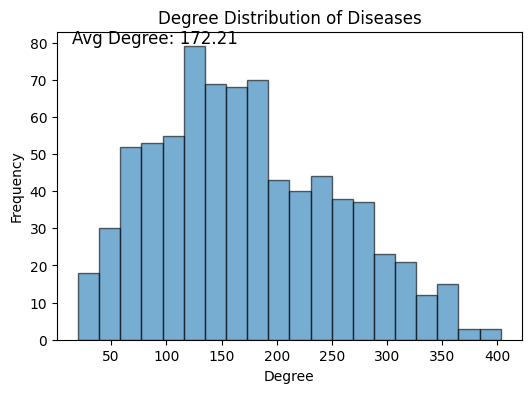

In [11]:
# Plot degree distribution histogram (linear scale)
plt.figure(figsize=(6, 4))
plt.hist(degrees, bins=20, alpha=0.6, edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Diseases")
plt.figtext(0.15, 0.85, f'Avg Degree: {average_degree:.2f}', fontsize=12)
plt.show()

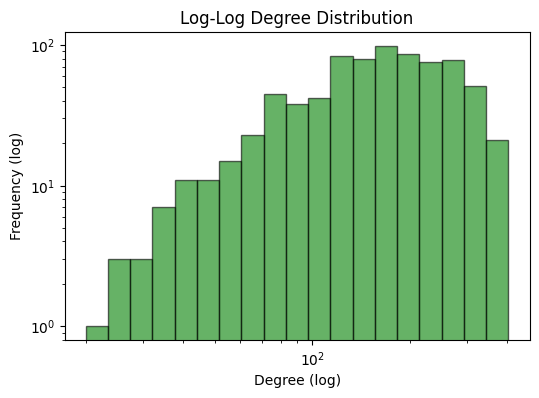

In [12]:
# Log-Log Plot (to check power-law behavior)
plt.figure(figsize=(6, 4))
plt.hist(degrees, bins=np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), 20), color='g', alpha=0.6, edgecolor='black')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (log)")
plt.ylabel("Frequency (log)")
plt.title("Log-Log Degree Distribution")
plt.show()

In [13]:
# Fit a power-law distribution
fit = powerlaw.Fit(degrees)

Calculating best minimal value for power law fit


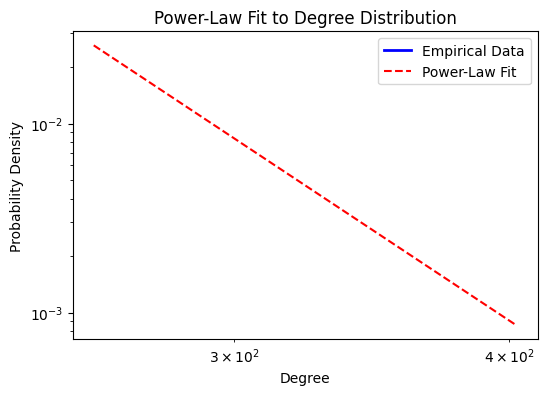

In [14]:
# Plot with fitted power-law
fig = plt.figure(figsize=(6, 4))
fit.plot_pdf(color='b', linewidth=2, label="Empirical Data")
fit.power_law.plot_pdf(color='r', linestyle="--", label="Power-Law Fit")
plt.xlabel("Degree")
plt.ylabel("Probability Density")
plt.legend()
plt.title("Power-Law Fit to Degree Distribution")
plt.show()


In [34]:
print(f"Estimated power-law exponent: {fit.power_law.alpha:.2f}")
print(f"Power-law fit xmin: {fit.power_law.xmin}")

Estimated power-law exponent: 7.71
Power-law fit xmin: 259.0


The power-law exponent 7.81 indicates that the network is less scale-free and has a more uniform distribution of node degrees.
Generally the exponent is in the range of 2 to 3. 

Exponent of 7.71 is high and suggests that most nodes in the network have relatively low degrees compared to a few high-degree nodes (like a strongly skewed distribution).

It is relatively hubless and has less hierarchical structure compared to networks with typical scale-free properties.

The xmin value indicates that for degrees greater than or equal to 259, the network’s degree distribution follows a power-law.


## Plotting Degree Distribution
Code below is modified from the CPSC 572 NetworkX Winter 2025 Lecture.

### Log-Log Plot

In [16]:
# Get 10 logarithmically spaced bins between kmin and kmax
# buckets un from minimum degree to maximum degree
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

In [17]:
import matplotlib.ticker as ticker

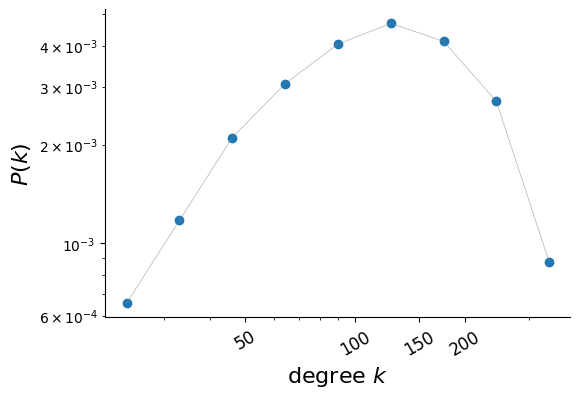

In [18]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# Adding a line for better visual 
plt.loglog(x, density, linestyle='-', color='gray', linewidth=0.5, alpha=0.6, label="Trend Line")

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Adjusting x-axis numbers for readability
custom_ticks = [50, 100, 150, 200]  
ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_ticks)  # Ensure they display as integers

ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(axis='x', which='major', labelsize=12, rotation=30)  


# Show the plot
plt.show()

### Linear-Linear Plot

In [19]:
# CODE BELOW TAKEN FROM CPSC 572 LECTURE ON NETWORKX (WINTER 2025)
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, kmax, num=10)  # number of bins (num=10) can be changed

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

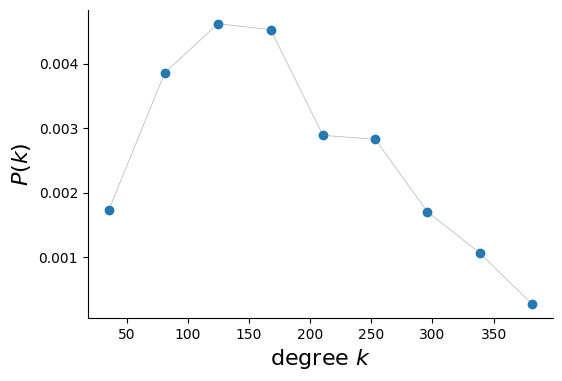

In [20]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# Adding a line for better visual 
plt.plot(x, density, linestyle='-', color='gray', linewidth=0.5, alpha=0.6, label="Trend Line")

# remove right and top boundaries
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

# Visualizing the Network

In [21]:
import random

### Using force-based or "spring" layout algorithm for 50% of dataset

In [22]:
# Subsample about 25% of the nodes
total_nodes = len(G.nodes())
sampled_nodes = int(total_nodes * 0.25) # Extract 25% of all nodes
final_sampled_nodes = random.sample(G.nodes(), sampled_nodes)

/var/folders/3g/tr_l5b9n3s9b6j991s4y7pm00000gn/T/ipykernel_33843/4194585315.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  final_sampled_nodes = random.sample(G.nodes(), sampled_nodes)


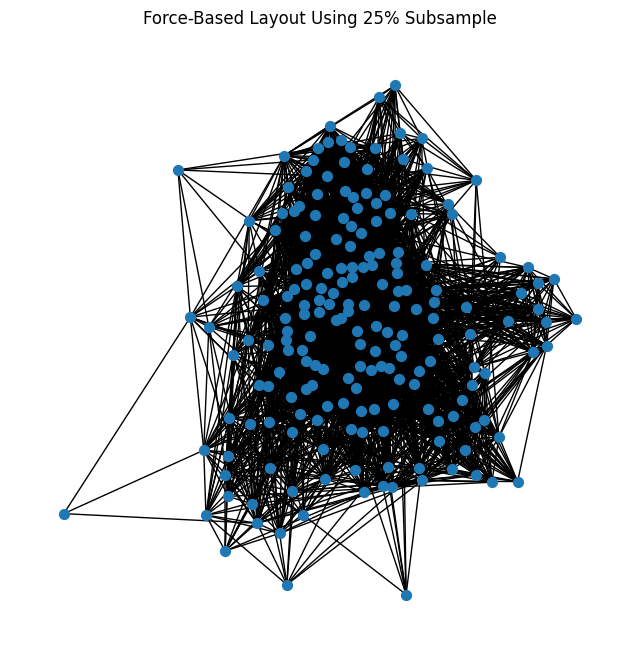

In [23]:
# Create a subgraph of nodes
subgraph = G.subgraph(final_sampled_nodes)

# Visualize the subgraph using Force-Based Layout
plt.figure(figsize=(8, 8))
plt.title("Force-Based Layout Using 25% Subsample")
pos_force = nx.spring_layout(subgraph, seed=42)  # force-directed layout
nx.draw(subgraph, pos=pos_force, with_labels=False, node_size=50, edge_color="black")
plt.show()

### Using force-based or "spring" layout algorithm for 10% of dataset

In [24]:
# Subsample about 10% of the nodes
total_nodes = len(G.nodes())
sampled_nodes = int(total_nodes * 0.10) # Extract 10% of all nodes
final_sampled_nodes = random.sample(G.nodes(), sampled_nodes)

/var/folders/3g/tr_l5b9n3s9b6j991s4y7pm00000gn/T/ipykernel_33843/126876050.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  final_sampled_nodes = random.sample(G.nodes(), sampled_nodes)


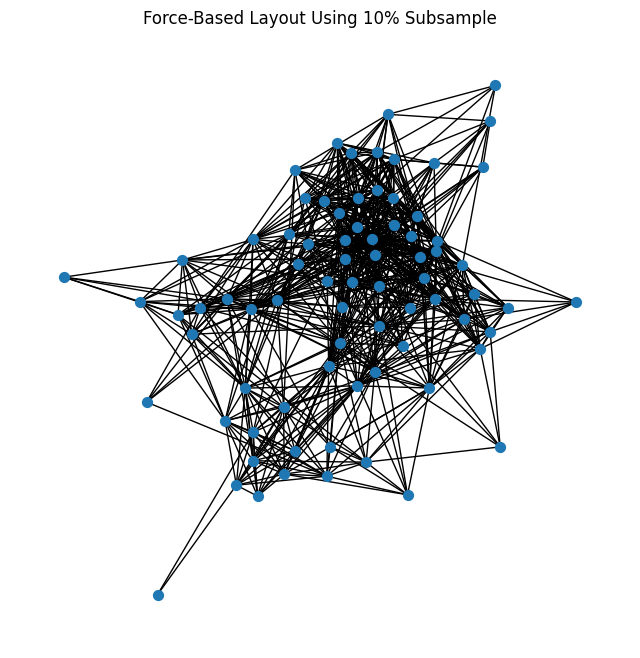

In [25]:
# Create a subgraph of nodes
subgraph = G.subgraph(final_sampled_nodes)

# Visualize the subgraph using Force-Based Layout
plt.figure(figsize=(8, 8))
plt.title("Force-Based Layout Using 10% Subsample")
pos_force = nx.spring_layout(subgraph, seed=42)  # force-directed layout
nx.draw(subgraph, pos=pos_force, with_labels=False, node_size=50, edge_color="black")
plt.show()

### Using the fcircular layout algorithm using 10% of nodes

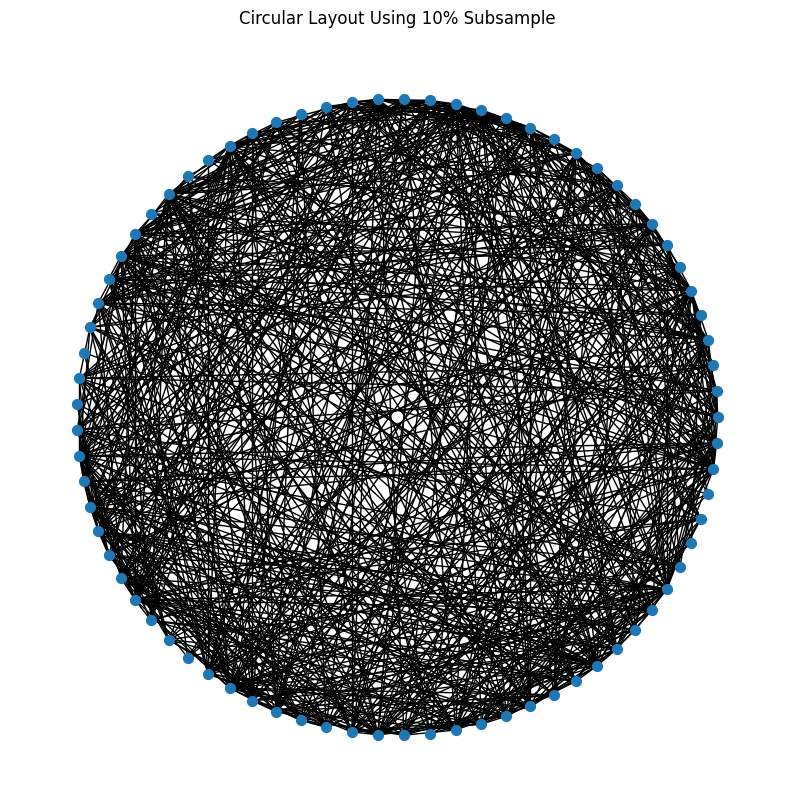

In [26]:
plt.figure(figsize=(10, 10))
plt.title("Circular Layout Using 10% Subsample")
pos_circular = nx.circular_layout(subgraph)  # circular layout
nx.draw(subgraph, pos=pos_circular, with_labels=False, node_size=50, edge_color="black")
plt.show()

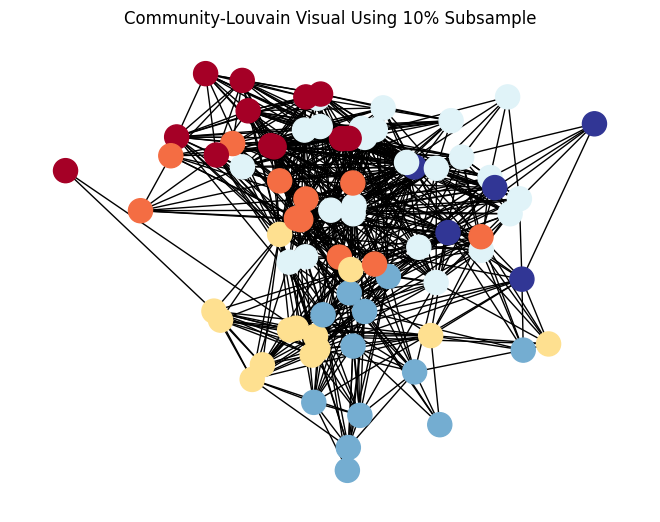

In [28]:
import community as community_louvain

# Detect communities using Louvain method
partition = community_louvain.best_partition(G)

# Color nodes based on community detection results
node_color = [partition[node] for node in subgraph.nodes()]

# Plot with community-based colors
pos = nx.spring_layout(G)
nx.draw(subgraph, pos, node_color=node_color, cmap=plt.cm.RdYlBu, node_size=300)
plt.title("Community-Louvain Visual Using 10% Subsample")
plt.show()


# Centrality Measures

In [29]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

In [ ]:
print("Top 5 diseases by Degree Centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 diseases by Degree Centrality: [('hypokalemia', 0.522020725388601), ('drug reaction', 0.5077720207253886), ('pain after an operation', 0.5051813471502591), ('shingles (herpes zoster)', 0.49093264248704666), ('acute stress reaction', 0.48704663212435234)]


### Insights on diseases with highest degree centrality
These diseases have the highest number of direct symptom based connections to other diseases

**Drug reaction**:
    high connectivity suggests drug-induced conditions are frequently misdiagnosed as other illnesses.
    
**Pain after an operation**:
    Post operation pain is common across many surgical procedures and may be mistaken for underlying infections or some other issues
    
**Shingles**:
    High centrality suggests it may often be confused with other viral infections or autoimmune conditions.

**Acute Stress Reaction**:
    indicates stress-related symptoms might contribute to misdiagnosis of physical diseases.
    

In [31]:
print("Top 5 diseases by Betweenness Centrality:", sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

#Shingles:
    #Shingles has symptoms (nerve pain, rashes, fever) that overlap with both viral infections and autoimmune conditions.
    #This suggests shingles acts as a key diagnostic confusion point, potentially being mistaken for other neurological, dermatological, or viral illnesses.
    
#Parasitic disease:
    #Many parasitic diseases have vague symptoms (abdominal pain, diarrhea, fatigue), which means they might connect conditions like food poisoning, viral infections, and malabsorption disorders.
    
#Drug Reaction:
    #High betweenness suggests that drug reactions bridge multiple medical conditions, leading to frequent confusion with infections, allergies, or autoimmune issues.
    
#These diseases connect different clusters, making them major misdiagnosis risks.
#Doctors should carefully differentiate these from diseases in both of their clusters.



Top 5 diseases by Betweenness Centrality: [('shingles (herpes zoster)', 0.008302474423198791), ('lyme disease', 0.006565076328624316), ('parasitic disease', 0.005502711106188218), ('lymphadenitis', 0.005303623907557194), ('drug reaction', 0.005164641297152865)]


### Insights on diseases with highest betweenness centrality
**Shingles**:
    Shingles has symptoms (nerve pain, rashes, fever) that overlap with both viral infections and autoimmune conditions.
    This suggests shingles acts as a key diagnostic confusion point, potentially being mistaken for other neurological, dermatological, or viral illnesses.
    
**Parasitic disease**:
    Many parasitic diseases have vague symptoms (abdominal pain, diarrhea, fatigue), which means they might connect conditions like food poisoning, viral infections, and malabsorption disorders.
    
**Drug Reaction**:
    High betweenness suggests that drug reactions bridge multiple medical conditions, leading to frequent confusion with infections, allergies, or autoimmune issues.
    
These diseases connect different clusters, making them major misdiagnosis risks.
Doctors should carefully differentiate these from diseases in both of their clusters.

In [32]:
print("Top 5 diseases by Closeness Centrality:", sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
#These diseases are highly reachable in the network, meaning they are common misdiagnosis or differential diagnosis candidates.
#Doctors should always consider these diseases in diagnostic decisions since they connect to many symptomatically similar conditions.
#These diseases may be important in machine learning models for automated diagnosis, as they likely appear as early-stage possibilities in differential diagnoses.



Top 5 diseases by Closeness Centrality: [('hypokalemia', 0.6765994741454864), ('drug reaction', 0.6701388888888888), ('pain after an operation', 0.6689774696707106), ('shingles (herpes zoster)', 0.6626609442060086), ('acute stress reaction', 0.660958904109589)]


### Insights on diseases with highest closeness centrality
* Hypokalemia
* Drug reaction
* Pain after an operation
* Shingles
* Acute stress reaction


These diseases are highly reachable in the network, meaning they are common misdiagnosis or differential diagnosis candidates.
Doctors should always consider these diseases in diagnostic decisions since they connect to many symptomatically similar conditions.
These diseases may be important in machine learning models for automated diagnosis, as they likely appear as early-stage possibilities in differential diagnoses.



In [ ]:
print("Top 5 diseases by Eigenvector Centrality:", sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5])


Top 5 diseases by Eigenvector Centrality: [('hypokalemia', 0.0820095696120754), ('pain after an operation', 0.07735926826671709), ('gastritis', 0.07639006170018714), ('drug reaction', 0.07499439055255328), ('acute kidney injury', 0.07408833976707527)]


### Insights on diseases with highest eigenvector centrality

Since it is so interconnected, doctors should always consider checking for underlying causes of hypokalemia, as it may be a secondary symptom of another major condition.


understanding postoperative symptom patterns could help reduce unnecessary tests and avoid confusion with unrelated conditions.

These diseases act as key “hubs” in the network, influencing diagnosis patterns across multiple categories.


Diseases with high eigenvector centrality may serve as key “signals” in differential diagnosis algorithms.


Misdiagnosis risks are high when these diseases are confused with others that have similar symptoms but different underlying causes.